# Desarrollo de un modelo de IA para la detección temprana del Parkinson

## Importación de librerías y configuraciones

In [57]:
# Librerías estándar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: preprocesado y modelado
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix

# XGBoost
from xgboost import XGBClassifier

In [2]:
# Configuraciones
pd.set_option('display.max_columns', None)      # Permitir que se muestren todas las columnas
pd.set_option('display.max_rows', None)         # Permitir que se muestren todas las filas

sns.set(style="whitegrid")                      # Estilo de las gráficas
palette_set2 = sns.color_palette('Set2')        # Paleta de colores Set2

## Carga de datos y exploración inicial

A continuación se describen las características acústicas de los audios recogidas en `audio_features.csv`:

| Variable       | Descripción                                                                                             |
|----------------|---------------------------------------------------------------------------------------------------------|
| `AudioPath`    | Ruta al archivo de audio correspondiente.                                                              |
| `Jitter`       | Variación absoluta del período fundamental, indicador de inestabilidad en la frecuencia (irregularidad).|
| `rJitter`      | Jitter relativo: variación del período fundamental en porcentaje.                                       |
| `RAP`          | Jitter relativo promedio absoluto: medida de variación entre ciclos consecutivos.                       |
| `rPPQ`         | Pitch perturbation quotient: variación de frecuencia a corto plazo.                                     |
| `rSPPQ`        | Smoothed pitch perturbation quotient: versión suavizada del PPQ.                                        |
| `ShimmerDb`    | Variación de amplitud (en dB) entre ciclos consecutivos (amplitud perturbation).                        |
| `rShimmer`     | Shimmer relativo: porcentaje de variación de amplitud entre ciclos.                                     |
| `APQ`          | Amplitude perturbation quotient: variación promedio de amplitud.                                        |
| `sAPQ`         | Smoothed amplitude perturbation quotient: versión suavizada del APQ.                                    |
| `FTRI`         | Frequency tremor intensity index: mide la intensidad del temblor en frecuencia.                         |
| `ATRI`         | Amplitude tremor intensity index: mide la intensidad del temblor en amplitud.                           |
| `FFTR`         | Fundamental frequency tremor frequency: frecuencia del temblor en el tono fundamental.                 |
| `ATRF`         | Amplitude tremor frequency: frecuencia del temblor en amplitud.                                         |
| `NNE`          | Noise-to-noise energy ratio: proporción de energía del ruido respecto al tono.                          |
| `HNR`          | Harmonics-to-noise ratio: relación entre la energía de los armónicos y el ruido.                        |
| `CHNR`         | Cepstral harmonics-to-noise ratio: variante cepstral del HNR.                                           |
| `GNE`          | Glottal-to-noise excitation ratio: medida de la relación señal-ruido glotal.                           |
| `CPP`          | Cepstral peak prominence: prominencia del pico cepstral (relacionado con la calidad vocal).             |


In [3]:
# Cargar las características extraídas de los audios del CSV
df_features = pd.read_csv("audio_features/audio_features.csv")

# Mostrar primeras filas
df_features.head()

,AudioPath,Jitter,rJitter,RAP,rPPQ,rSPPQ,ShimmerDb,rShimmer,APQ,sAPQ,FTRI,ATRI,FFTR,ATRF,NNE,HNR,CHNR,GNE,CPP
0,../data/audios/HC_A1_0034.wav,90.143459,1.389974,0.829234,0.867956,2.028272,0.306230,3.467983,2.583073,3.371838,4.090909,10.279720,0.031869,2.439872,-14.178498,-16.783000,-14.781723,-10.849439,[20.68591808 19.51792063 22.63979844 21.873139...
1,../data/audios/HC_A1_0036.wav,45.845768,1.053877,0.648728,0.618244,0.710986,0.274391,3.138128,2.258142,3.131371,5.646607,10.022727,0.006287,0.815829,-18.391510,-13.384067,-15.803058,-11.950162,[23.79050636 23.23705045 24.50422643 25.958219...
2,../data/audios/HC_A1_0045.wav,388.205756,3.534064,2.127018,1.955301,1.834815,0.902313,10.319354,6.424677,6.655715,9.111570,10.022727,0.020949,0.531205,-4.170562,-3.134168,-2.363848,-2.473592,[16.72090753 19.91639446 19.64481155 16.706628...
3,../data/audios/HC_A1_0048.wav,38.528686,0.473524,0.284452,0.319551,0.516492,0.396074,4.519425,3.148559,5.212512,10.279720,10.279720,0.003805,0.762209,-15.074605,-10.914691,-11.788722,-16.150904,[25.19213528 20.43461294 22.18909878 26.191502...
4,../data/audios/HC_A1_0049.wav,35.880701,0.702138,0.433132,0.436095,0.727694,0.320643,3.663877,2.811715,5.060773,4.310850,10.022727,0.004411,0.401193,-20.660361,-32.320082,-27.659973,-29.763608,[25.84298304 25.87258202 24.73373832 24.732789...


## Limpieza básica de datos

In [4]:
# Limpiar nombres de columnas (quitar espacios en blanco al inicio y final)
df_features.columns = df_features.columns.str.strip()

In [5]:
# Dimensiones del datafdrame
print(f"Filas: {df_features.shape[0]}, Columnas: {df_features.shape[1]}")

Filas: 1035, Columnas: 19


In [6]:
# Tipos de datos y valores nulos
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AudioPath  1035 non-null   object 
 1   Jitter     1035 non-null   float64
 2   rJitter    1035 non-null   float64
 3   RAP        1035 non-null   float64
 4   rPPQ       1035 non-null   float64
 5   rSPPQ      1035 non-null   float64
 6   ShimmerDb  1035 non-null   float64
 7   rShimmer   1035 non-null   float64
 8   APQ        1035 non-null   float64
 9   sAPQ       1035 non-null   float64
 10  FTRI       1031 non-null   float64
 11  ATRI       1031 non-null   float64
 12  FFTR       1031 non-null   float64
 13  ATRF       1031 non-null   float64
 14  NNE        1035 non-null   float64
 15  HNR        1035 non-null   float64
 16  CHNR       1035 non-null   float64
 17  GNE        1035 non-null   float64
 18  CPP        1035 non-null   object 
dtypes: float64(17), object(2)
memory usage: 153.8+ K

In [7]:
# Estadísticas básicas de columnas numéricas
df_features.describe()

,Jitter,rJitter,RAP,rPPQ,rSPPQ,ShimmerDb,rShimmer,APQ,sAPQ,FTRI,ATRI,FFTR,ATRF,NNE,HNR,CHNR,GNE
count,1035.000000,1035.000000,1035.000000,1035.000000,1035.000000,1035.000000,1035.000000,1035.000000,1035.000000,1031.000000,1031.000000,1031.000000,1031.000000,1.035000e+03,1.035000e+03,1.035000e+03,1.035000e+03
mean,130.727899,1.965434,1.189525,1.334302,1.708511,0.490905,5.186506,3.622006,5.413896,8.014644,9.889821,0.211321,4.252173,-1.011023e+01,-9.937275e+00,-1.005005e+01,-9.867708e+00
std,142.362790,1.975441,1.194615,1.716466,2.322187,0.568773,5.088113,3.635552,5.527009,2.623868,1.124871,1.612465,7.291117,6.297008e+00,6.439265e+00,7.753089e+00,6.089066e+00
min,12.086053,0.233385,0.139921,0.196695,0.307830,0.014437,0.166928,0.147487,0.234312,2.277893,2.239716,0.000037,0.002726,-3.277896e+01,-3.375358e+01,-1.565356e+02,-2.998886e+01
25%,48.889464,0.793453,0.473246,0.515360,0.724561,0.251619,2.829733,1.999026,3.131697,5.310287,10.022727,0.003829,1.104879,-1.431900e+01,-1.419005e+01,-1.389026e+01,-1.409423e+01
50%,85.807050,1.337290,0.813174,0.813185,1.040573,0.361379,3.996853,2.838778,4.260799,9.545455,10.279720,0.010702,2.427264,-8.949588e+00,-8.833055e+00,-8.861781e+00,-9.020266e+00
75%,161.693345,2.306977,1.413908,1.464884,1.713484,0.537040,5.801938,4.069991,5.763564,10.279720,10.279720,0.028489,4.686095,-5.060850e+00,-4.622140e+00,-4.939764e+00,-4.733109e+00
max,1687.631027,21.798490,13.447084,25.950894,28.757660,7.758631,63.330097,50.161212,75.149966,10.279720,10.279720,31.786674,72.743037,9.640000e-16,9.640000e-16,9.640000e-16,9.640000e-16


In [8]:
# Eliminación de duplicados
num_duplicados = df_features.duplicated().sum()
print(f"Filas duplicadas: {num_duplicados}")

Filas duplicadas: 0


## Análisis exploratorio de datos (EDA)

In [9]:
# Extraer el grupo de AudioPath
def extract_group(path):
    try:
        return path.split('/')[-1].split('_')[0]
    except Exception:
        return np.nan

df_features['Group'] = df_features['AudioPath'].apply(extract_group)

# Comprobar cuántas etiquetas hay de cada grupo
print("Distribución de etiquetas en 'Group':")
print(df_features['Group'].value_counts())

# Comprobar si quedan NaN en 'Group'
print("\nNúmero de valores NaN en 'Group':")
print(df_features['Group'].isna().sum())

Distribución de etiquetas en 'Group':
Group
PD    559
HC    476
Name: count, dtype: int64

Número de valores NaN en 'Group':
0


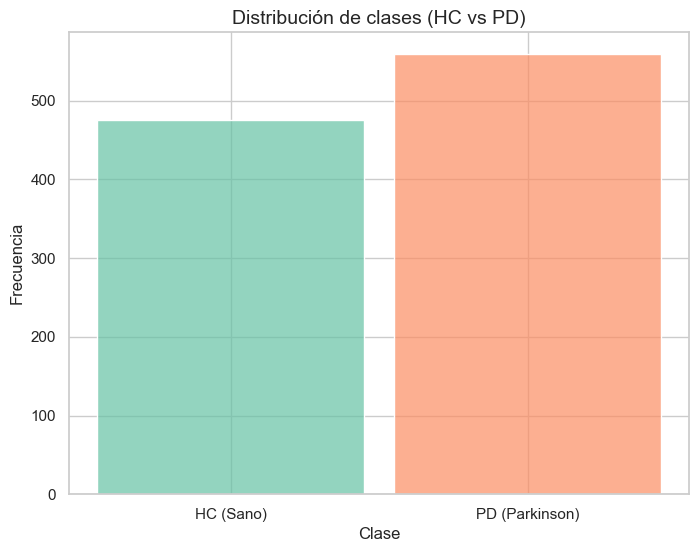

Group
PD    559
HC    476
Name: count, dtype: int64


In [10]:
plt.figure(figsize=(8, 6))
sns.histplot(
    data=df_features, x='Group', hue='Group', palette=[palette_set2[0], palette_set2[1]], shrink=0.9, binwidth=0.4, discrete=True, alpha=0.7
)
plt.title('Distribución de clases (HC vs PD)', fontsize=14)
plt.xlabel('Clase', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.legend([], [], frameon=False)
plt.xticks(ticks=[0, 1], labels=['HC (Sano)', 'PD (Parkinson)'])
plt.show()

# Mostrar los números exactos
print(df_features['Group'].value_counts())

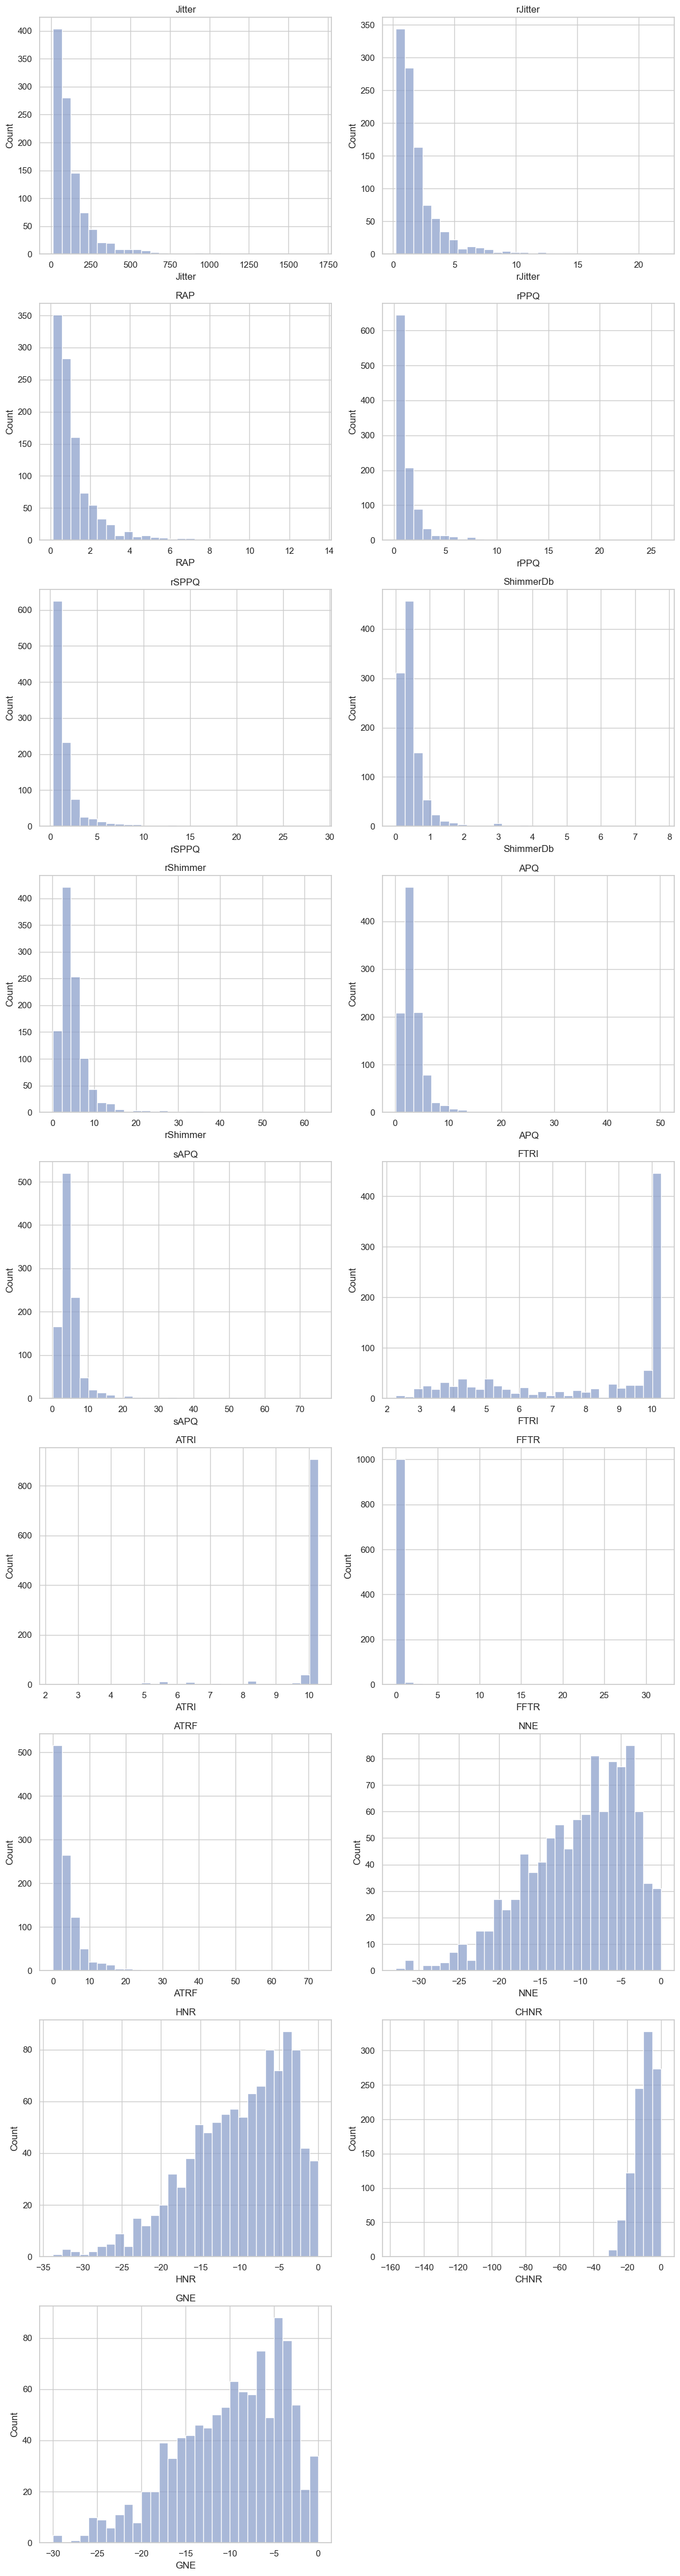

In [11]:
# Columnas numéricas y número de filas necesarias
num_cols = df_features.select_dtypes(include=['float64', 'int64']).columns
n_rows = (len(num_cols) + 1) // 2

plt.figure(figsize=(12, 5 * n_rows))

# Graficar histogramas 2 por fila
for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, 2, i)
    sns.histplot(df_features[col].dropna(), bins=30, color=palette_set2[2])
    plt.title(col)

plt.tight_layout()
plt.show()

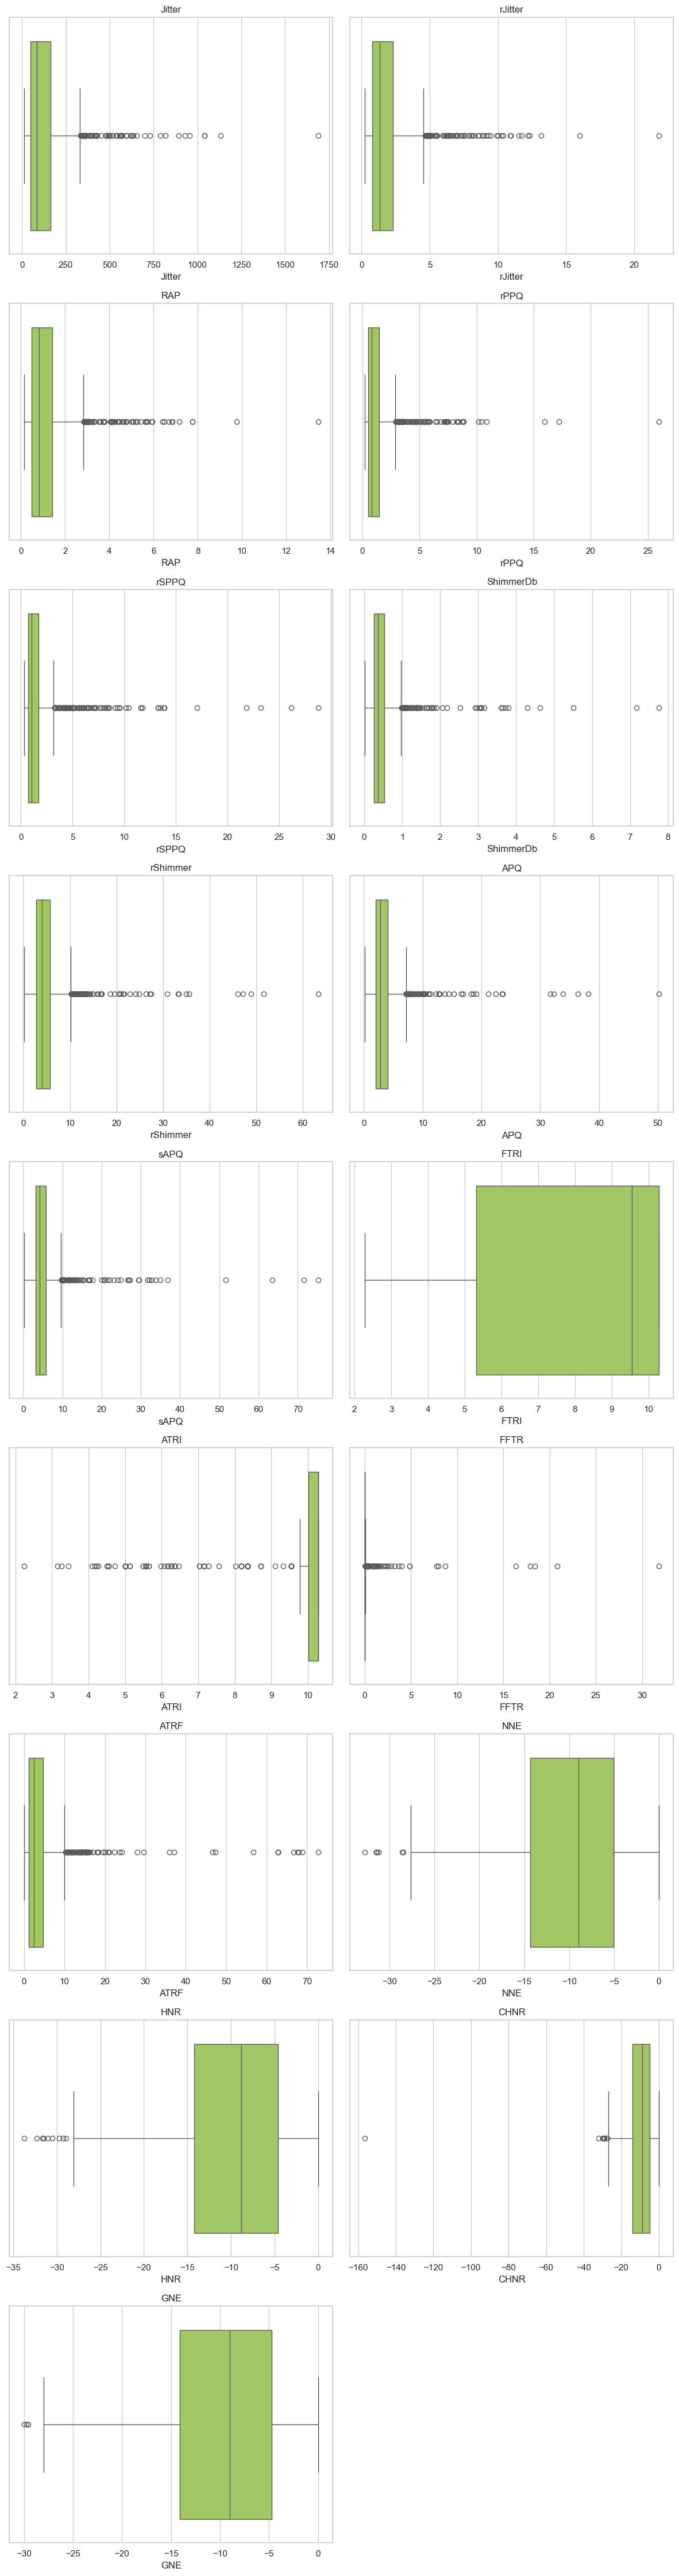

In [12]:
# Columnas numéricas y número de filas necesarias
num_cols = df_features.select_dtypes(include=['float64', 'int64']).columns
n_rows = (len(num_cols) + 1) // 2

plt.figure(figsize=(12, 5 * n_rows))

# Graficar boxplots, 2 por fila
for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, 2, i)
    sns.boxplot(x=df_features[col], color=palette_set2[4])
    plt.title(col)

plt.tight_layout()
plt.show()

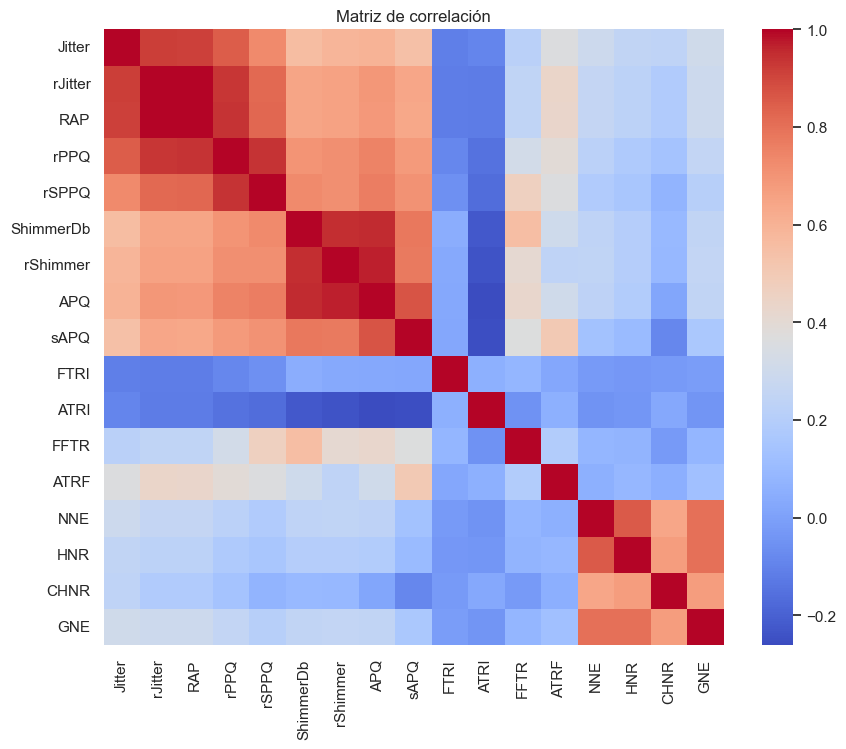

In [13]:
# Matriz de correlación
plt.figure(figsize=(10, 8))
corr = df_features[num_cols].corr()
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Matriz de correlación")
plt.show()

## Preprocesamiento de Datos (post-EDA)

In [14]:
# Calcular matriz de correlación absoluta entre variables numéricas
corr_matrix = df_features.select_dtypes(include=['number']).corr().abs()

# Crear un dataframe para marcar las correlaciones muy altas (umbral 0.95)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Umbral de correlación
threshold = 0.95

# Encontrar columnas que tienen alguna correlación mayor al umbral
to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > threshold)]

# Mostrar variables a eliminar por alta correlación
print(f"Variables a eliminar (correlación > {threshold}): {to_drop}")

# Crear dataframe sin esas variables
df_reduced = df_features.drop(columns=to_drop)

# Opcional: mostrar nueva forma del dataframe
print(f"Dimensiones original: {df_features.shape}, reducido: {df_reduced.shape}")

Variables a eliminar (correlación > 0.95): ['RAP', 'APQ']
Dimensiones original: (1035, 20), reducido: (1035, 18)


In [15]:
# Hacer una copia para no tocar el original
df_model = df_reduced.copy()

# Eliminar columnas irrelevantes para el modelo
df_model = df_model.drop(columns=['AudioPath'])

In [16]:
# Convertir el target a binario
df_model['Group'] = df_model['Group'].map({'HC': 0, 'PD': 1})

In [17]:
# Eliminar la columna CPP
df_model = df_model.drop(columns=["CPP"])

## División del conjunto de datos

In [18]:
# Separar X e y
X = df_model.drop(columns=['Group'])
y = df_model['Group']

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Modelo de Regresión Logística

### Construcción del modelo

In [19]:
# Pipeline con imputación + escalado + modelo
pipeline_lr = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear'))
])

### Entrenamiento inicial + ajuste de hiperparámetros con validación cruzada

In [20]:
# Grid de hiperparámetros para búsqueda
param_grid_lr = {
    "logreg__C": [0.01, 0.1, 1, 10, 100],       # valores de C para regularización
    "logreg__penalty": ["l1", "l2"],            # tipo de penalización
    "logreg__solver": ["liblinear"]             # compatible con l1 y l2
}

In [21]:
# GridSearch con validación cruzada (5 folds)
grid_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

In [22]:
# Entrenamiento del modelo
grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,estimator,Pipeline(step...liblinear'))])
,param_grid,"{'logreg__C': [0.01, 0.1, ...], 'logreg__penalty': ['l1', 'l2'], 'logreg__solver': ['liblinear']}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,missing_values,nan


In [23]:
# Resultados
print("Mejores parámetros:", grid_lr.best_params_)
print("Mejor AUC en CV:", grid_lr.best_score_)

Mejores parámetros: {'logreg__C': 100, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
Mejor AUC en CV: 0.674315201520997


In [24]:
# Evalúa el mejor modelo con CV para confirmar generalización
best_model_lr = grid_lr.best_estimator_

cv_scores = cross_val_score(best_model_lr, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
print(f"AUC CV scores: {cv_scores}")
print(f"Media AUC CV: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")

AUC CV scores: [0.74707602 0.58611111 0.68918722 0.61635127 0.73285038]
Media AUC CV: 0.674 ± 0.063


### Evaluación de los modelos

In [25]:
# Predicciones en test
y_pred_lr = grid_lr.predict(X_test)
y_proba_lr = grid_lr.predict_proba(X_test)[:,1]

print("=== Regresión Logística ===")
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred_lr))

# AUC ROC
auc_roc_lr = roc_auc_score(y_test, y_proba_lr)
print(f"AUC ROC en test: {auc_roc_lr:.3f}")

=== Regresión Logística ===
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.57      0.68      0.62        95
           1       0.68      0.56      0.61       112

    accuracy                           0.62       207
   macro avg       0.62      0.62      0.62       207
weighted avg       0.63      0.62      0.62       207

AUC ROC en test: 0.652


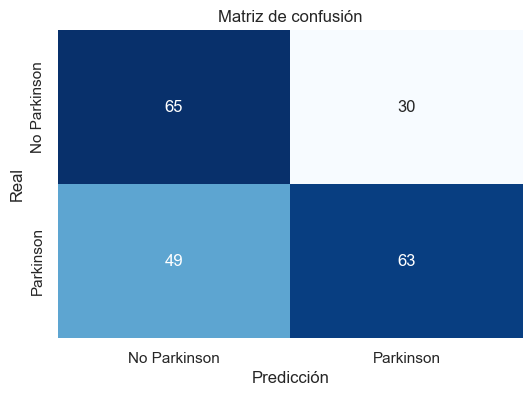

In [26]:
# Matriz de confusión
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["No Parkinson", "Parkinson"],
            yticklabels=["No Parkinson", "Parkinson"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión")
plt.show()

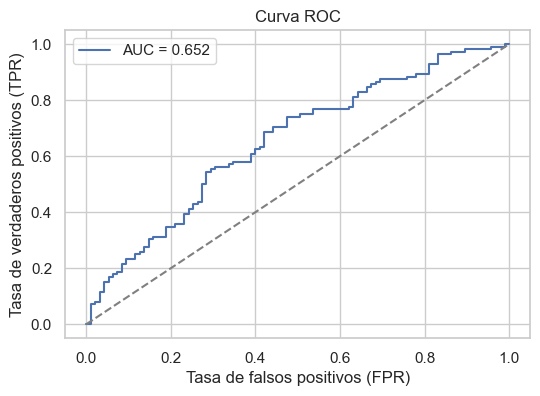

In [27]:
# Curva ROC
fpr_lr, tpr_lr, thresholds = roc_curve(y_test, y_proba_lr)

plt.figure(figsize=(6, 4))
plt.plot(fpr_lr, tpr_lr, label=f"AUC = {auc_roc_lr:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title("Curva ROC")
plt.legend()
plt.grid(True)
plt.show()

## Modelo SVM

### Construcción del modelo

In [28]:
# Pipeline SVM
pipeline_svm = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("svc", SVC(probability=True))                  # Para poder calcular AUC ROC
])

### Entrenamiento inicial + ajuste de hiperparámetros con validación cruzada

In [29]:
# Grid de hiperparámetros SVM
param_grid_svm = {
    "svc__C": [0.1, 1, 10],
    "svc__kernel": ["linear", "rbf"],
    "svc__gamma": ["scale", "auto"]
}

In [30]:
# GridSearchCV SVM
grid_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=5, scoring="roc_auc", n_jobs=-1)

In [31]:
# Entrenamiento del modelo
grid_svm.fit(X_train, y_train)

,estimator,Pipeline(step...ility=True))])
,param_grid,"{'svc__C': [0.1, 1, ...], 'svc__gamma': ['scale', 'auto'], 'svc__kernel': ['linear', 'rbf']}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,missing_values,nan


In [32]:
# Resultados
print("Mejores parámetros:", grid_svm.best_params_)
print("Mejor AUC en CV:", grid_svm.best_score_)

Mejores parámetros: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Mejor AUC en CV: 0.694978235510465


### Evaluación de los modelos

In [33]:
# Predicciones y probabilidades
y_pred_svm = grid_svm.best_estimator_.predict(X_test)
y_proba_svm = grid_svm.best_estimator_.predict_proba(X_test)[:,1]

print("=== SVM ===")
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred_svm))

# AUC ROC
auc_roc_svm = roc_auc_score(y_test, y_proba_svm)
print(f"AUC ROC en test: {auc_roc_svm:.3f}")

=== SVM ===
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.67      0.63      0.65        95
           1       0.70      0.74      0.72       112

    accuracy                           0.69       207
   macro avg       0.69      0.69      0.69       207
weighted avg       0.69      0.69      0.69       207

AUC ROC en test: 0.727


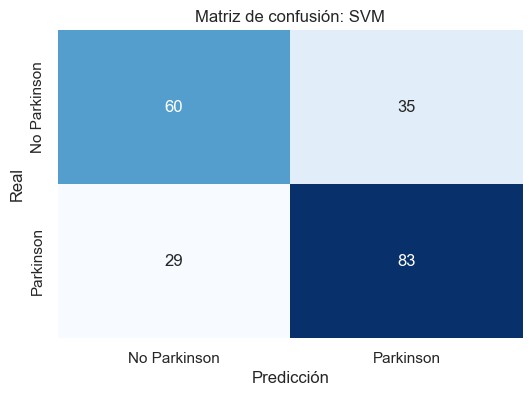

In [34]:
# Matriz de confusión
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Matriz de confusión (heatmap)
plt.figure(figsize=(6,4))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Parkinson", "Parkinson"],
            yticklabels=["No Parkinson", "Parkinson"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión: SVM")
plt.show()

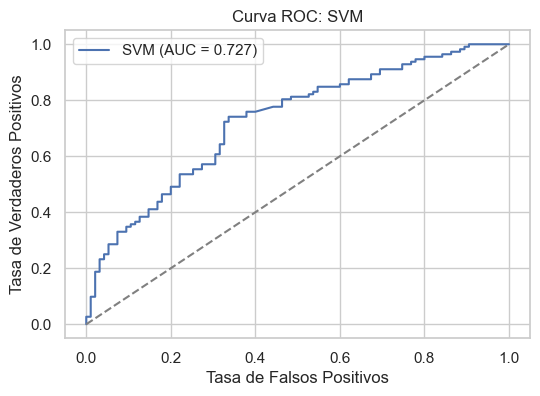

In [35]:
# Curva ROC
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)

plt.figure(figsize=(6,4))
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {auc_roc_svm:.3f})")
plt.plot([0,1], [0,1], linestyle="--", color="grey")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC: SVM")
plt.legend()
plt.show()

## Modelo Random Forest

### Construcción del modelo

In [36]:
# Pipeline Random Forest
pipeline_rf = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),   # imputar NaN con media
    ("scaler", StandardScaler()),                   # opcional para RF (se puede quitar si quieres)
    ("rf", RandomForestClassifier(random_state=42))
])

### Entrenamiento inicial + ajuste de hiperparámetros con validación cruzada

In [37]:
# Grid de hiperparámetros Random Forest
param_grid_rf = {
    "rf__n_estimators": [100, 200, 500],
    "rf__max_depth": [None, 10, 20, 30],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 4],
    "rf__max_features": ["sqrt", "log2", None]
}

In [38]:
# GridSearchCV con validación cruzada (5 folds)
grid_rf = GridSearchCV(
    pipeline_rf, param_grid_rf, cv=5,
    scoring="roc_auc", n_jobs=-1, verbose=1
)

In [39]:
# Entrenamiento del modelo Random Forest
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'rf__max_depth': [None, 10, ...], 'rf__max_features': ['sqrt', 'log2', ...], 'rf__min_samples_leaf': [1, 2, ...], 'rf__min_samples_split': [2, 5, ...], ...}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,missing_values,nan


In [40]:
# Resultados
print("Mejores parámetros:", grid_rf.best_params_)
print("Mejor AUC en CV:", grid_rf.best_score_)

Mejores parámetros: {'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Mejor AUC en CV: 0.7645172345231483


### Evaluación de los modelos

In [41]:
# Predicciones y probabilidades
y_pred_rf = grid_rf.best_estimator_.predict(X_test)
y_proba_rf = grid_rf.best_estimator_.predict_proba(X_test)[:,1]

# Reporte de clasificación
print("=== Random Forest ===")
print("Reporte de clasificación:\n", classification_report(y_test, y_pred_rf))

# AUC ROC
auc_roc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"AUC ROC en test: {auc_roc_rf:.3f}")

=== Random Forest ===
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.61      0.53      0.56        95
           1       0.64      0.71      0.68       112

    accuracy                           0.63       207
   macro avg       0.62      0.62      0.62       207
weighted avg       0.63      0.63      0.62       207

AUC ROC en test: 0.716


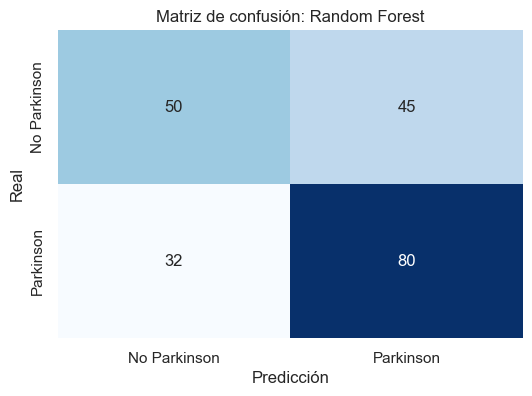

In [42]:
# Matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Matriz de confusión (heatmap)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Parkinson", "Parkinson"],
            yticklabels=["No Parkinson", "Parkinson"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión: Random Forest")
plt.show()

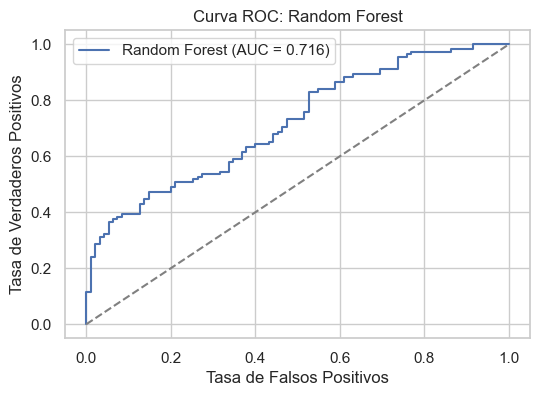

In [43]:
# Curva ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(6,4))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_roc_rf:.3f})")
plt.plot([0,1], [0,1], linestyle="--", color="grey")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC: Random Forest")
plt.legend()
plt.show()

## Gradient Boosting

### Construcción del modelo

In [53]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Pipeline con imputación + escalado + XGBoost
pipeline_xgb = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(eval_metric='logloss', random_state=42))
])

### Entrenamiento inicial + ajuste de hiperparámetros con validación cruzada

In [54]:
# Grid de hiperparámetros para XGBoost
param_grid_xgb = {
    "xgb__n_estimators": [100, 200, 500],
    "xgb__max_depth": [3, 5, 7],
    "xgb__learning_rate": [0.01, 0.1, 0.2],
    "xgb__subsample": [0.7, 1.0],
    "xgb__colsample_bytree": [0.7, 1.0],
    "xgb__scale_pos_weight": [1, sum(y_train==0)/sum(y_train==1)]  # Balanceo clases
}

In [55]:
# GridSearchCV con validación cruzada (5 folds) y scoring AUC ROC
grid_xgb = GridSearchCV(
    pipeline_xgb,
    param_grid_xgb,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

In [56]:
# Entrenamiento del modelo
grid_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'xgb__colsample_bytree': [0.7, 1.0], 'xgb__learning_rate': [0.01, 0.1, ...], 'xgb__max_depth': [3, 5, ...], 'xgb__n_estimators': [100, 200, ...], ...}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,missing_values,nan


In [49]:
# Resultados
print("Mejores parámetros:", grid_xgb.best_params_)
print("Mejor AUC en CV:", grid_xgb.best_score_)

Mejores parámetros: {'xgb__colsample_bytree': 0.7, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 7, 'xgb__n_estimators': 500, 'xgb__scale_pos_weight': 1, 'xgb__subsample': 0.7}
Mejor AUC en CV: 0.7579319169561629


### Entrenamiento inicial + ajuste de hiperparámetros con validación cruzada

In [50]:
# Predicciones y probabilidades
y_pred_xgb = grid_xgb.best_estimator_.predict(X_test)
y_proba_xgb = grid_xgb.best_estimator_.predict_proba(X_test)[:,1]

# Reporte de clasificación
print("=== Gradient Boosting ===")
print("Reporte de clasificación:\n", classification_report(y_test, y_pred_xgb))

# AUC ROC
auc_roc_xgb = roc_auc_score(y_test, y_proba_xgb)
print(f"AUC ROC en test: {auc_roc_xgb:.3f}")

=== Gradient Boosting ===
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.63      0.54      0.58        95
           1       0.65      0.73      0.69       112

    accuracy                           0.64       207
   macro avg       0.64      0.63      0.63       207
weighted avg       0.64      0.64      0.64       207

AUC ROC en test: 0.725


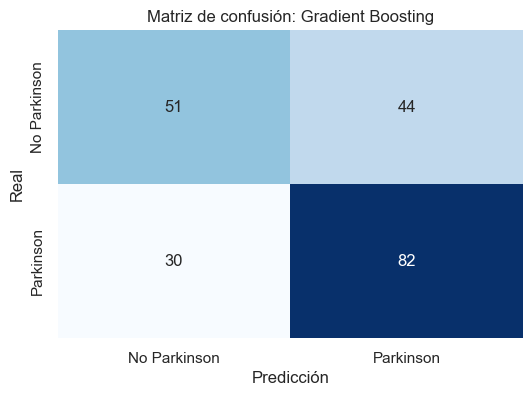

In [51]:
# Matriz de confusión
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Matriz de confusión (heatmap)
plt.figure(figsize=(6,4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Parkinson", "Parkinson"],
            yticklabels=["No Parkinson", "Parkinson"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión: Gradient Boosting")
plt.show()

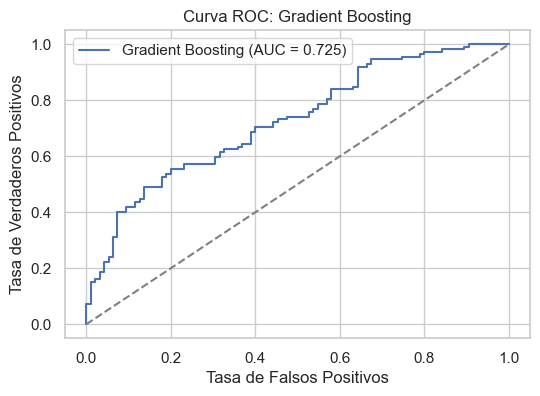

In [52]:
# Curva ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

plt.figure(figsize=(6,4))
plt.plot(fpr_xgb, tpr_xgb, label=f"Gradient Boosting (AUC = {auc_roc_xgb:.3f})")
plt.plot([0,1], [0,1], linestyle="--", color="grey")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC: Gradient Boosting")
plt.legend()
plt.show()